In [36]:
import pandas as pd
import re
import seaborn as sns
import glob
import cloudpickle
from matplotlib import pyplot as plt
%matplotlib inline
import numpy as np

In [25]:
disease_lookup = cloudpickle.load(open("pickles/disease_lookup_trunc.pkl", "rb" ) )
disease_list = cloudpickle.load(open("pickles/disease_list_trunc.pkl", "rb" ) )

disease_list=[{'name':a[0],'clin_ref':a[1],'synonyms':a[2],\
               'wiki_ref':'','clin_freq':0,'wiki_freq':0,'wiki_ref_freq':0,'forum_freq':0,'doctor_freq':0}\
              for a in disease_list]

for dis in disease_list:
    for k in dis['synonyms']:
        if(len(k)<len(dis['name'])):
            dis['name']=k

In [26]:
allFiles = glob.glob("diseasedata/nndss/NNDSS_-_Table_II*.csv")
frame = pd.DataFrame()
list_ = []
for file_ in allFiles:
    df = pd.read_csv(file_,index_col=None, header=0)
    df.columns = [col.strip() for col in df.columns]
    df=df.loc[(df['Reporting Area']=='UNITED STATES') & (df['MMWR Week']==37),:]
    c=[col for col in df.columns if "Cum 2015"in col and not "flag" in col]
    v=df[c].values[0]
    df_to=pd.DataFrame({'Disease': [col.split(',')[0].split('(')[0].split('\xc2')[0] for col in c], 'Total cases reported  2015' :v})
    list_.append(df_to)

In [27]:
df_infreq=pd.read_csv("diseasedata/nndss/NNDSS_-_Table_I._infrequently_reported_notifiable_diseases.csv",index_col=None, header=0)
list_.append(df_infreq[['Disease','Total cases reported  2015']].dropna())
df_reports = pd.concat(list_)
df_reports.columns=['Disease','Count']
df_reports['Disease']=df_reports['Disease'].apply(lambda x: x.lower())

In [28]:
from nltk import ngrams

def get_toks(txt,ngram_length):
    return [item for sublist in \
             [[" ".join(grams) for grams in ngrams(txt.split(), n)] \
             for n in range(ngram_length)] \
             for item in sublist]

def get_dislist_simple(diseases,text):
    choptext=dict([[a,0] for a in get_toks(text,4)])
    return [k for k in diseases if k in choptext]


In [29]:
for i,repo in enumerate(df_reports['Disease'].values):
    if(i%1000==0):
        print i
    txt = df_reports.loc[df_reports['Disease']==repo,'Disease'].values[0].lower()
    cnt = df_reports.loc[df_reports['Disease']==repo,'Count'].values[0]
    alldiags = get_dislist_simple(disease_lookup.keys(),txt)
    for k in set([disease_lookup[x] for x in alldiags]):
        disease_list[k]['clin_freq']=disease_list[k]['clin_freq']+cnt

0
1000


In [30]:
import cloudpickle
all_mentions = cloudpickle.load(open("pickles/alltext_labels.pkl", "rb" ) )
doc_mentions = cloudpickle.load(open("pickles/doctortext_labels.pkl", "rb" ) )


In [31]:
allment=all_mentions.sum(axis=0).tolist()[0]
docment=doc_mentions.sum(axis=0).tolist()[0]

for (i,m) in enumerate(allment):
    disease_list[i]['forum_freq']=disease_list[i]['forum_freq']+m 
for (i,m) in enumerate(docment):
    disease_list[i]['doctor_freq']=disease_list[i]['doctor_freq']+m 

In [32]:
df_wiki = pd.read_csv("diseasedata/wiki_list.csv",index_col=None, header=0)
df_wiki=df_wiki[['name','ref','views']]
df_wiki.columns=['Disease','Ref','Count']
df_wiki=df_wiki.dropna()

In [33]:

for i,repo in enumerate(df_wiki['Disease'].values):
    if(i%1000==0):
        print i
    txt = df_wiki.loc[df_wiki['Disease']==repo,'Disease'].values[0].lower()
    cnt = df_wiki.loc[df_wiki['Disease']==repo,'Count'].values[0]
    wiki= df_wiki.loc[df_wiki['Disease']==repo,'Ref'].values[0]
    alldiags = get_dislist_simple(disease_lookup.keys(),txt)
    for k in set([disease_lookup[x] for x in alldiags]):
        disease_list[k]['wiki_freq']=disease_list[k]['wiki_freq']+cnt
        if(disease_list[k]['wiki_ref_freq']<cnt):
            disease_list[k]['wiki_ref_freq']=cnt
            disease_list[k]['wiki_ref']=wiki

0
1000
2000
3000
4000


In [34]:
with open("pickles/disease_db.pkl", 'wb') as handle:
    cloudpickle.dump(disease_list, handle)

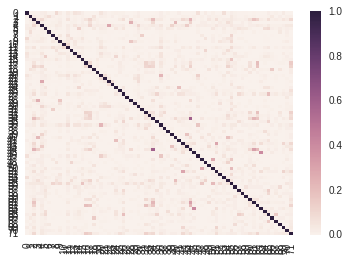

In [37]:
y=np.asarray(all_mentions.todense()).squeeze()

import seaborn as sns
%matplotlib inline
from sklearn.metrics.pairwise import cosine_similarity
cond_sim = cosine_similarity(y.T)
sns.heatmap(cond_sim)

In [38]:
with open("pickles/disease_similarity.pkl", 'wb') as handle:
    cloudpickle.dump(cond_sim, handle)